In [1]:
# ROI Uncertainty Analysis - Monte Carlo Simulation
# Quantify decision confidence with statistical modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ROI UNCERTAINTY & MONTE CARLO SIMULATION")
print("="*70)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
df_detailed = pd.read_csv("D:/Projects/End-to-end projects/7. Runway Kill-Switch Analytics/Data/initiative_monthly_detail.csv")
df_detailed['month'] = pd.to_datetime(df_detailed['month'])

ROI UNCERTAINTY & MONTE CARLO SIMULATION


In [2]:
# ============================================
# CALCULATE HISTORICAL ROI VOLATILITY
# ============================================

print("\n📊 Analyzing Historical ROI Volatility...")

roi_volatility = []

for init_id in df_detailed['initiative_id'].unique():
    init_data = df_detailed[df_detailed['initiative_id'] == init_id].copy()
    
    # Calculate monthly ROI
    init_data['roi'] = np.where(
        init_data['monthly_burn'] > 0,
        ((init_data['monthly_revenue'] - init_data['monthly_burn']) / init_data['monthly_burn']) * 100,
        0
    )
    
    roi_volatility.append({
        'initiative_id': init_id,
        'initiative_name': init_data['initiative_name'].iloc[0],
        'mean_roi': init_data['roi'].mean(),
        'std_roi': init_data['roi'].std(),
        'min_roi': init_data['roi'].min(),
        'max_roi': init_data['roi'].max(),
        'months_observed': len(init_data)
    })

df_volatility = pd.DataFrame(roi_volatility)
print(df_volatility.to_string(index=False))


📊 Analyzing Historical ROI Volatility...
    initiative_id           initiative_name    mean_roi   std_roi     min_roi     max_roi  months_observed
        CORE_SAAS        Core SaaS Platform   -9.424292 27.329461  -44.351167   38.436261               18
CONTENT_MARKETING Content Marketing Program  -85.322429  3.436207  -90.890665  -76.950264               16
       MOBILE_APP      Mobile App Expansion  -86.375987  5.487658  -92.181556  -72.818427               15
 ENTERPRISE_SALES     Enterprise Sales Team  -56.720169 20.854232  -83.125458  -25.916034               12
   APAC_EXPANSION            APAC Expansion -100.000000  0.000000 -100.000000 -100.000000               10
       AI_FEATURE           AI Feature Beta  -97.882982  0.375853  -98.507286  -97.437191                8


In [3]:
# ============================================
# MONTE CARLO SIMULATION
# ============================================

print("\n" + "="*70)
print("MONTE CARLO SIMULATION (10,000 ITERATIONS)")
print("="*70)

n_simulations = 10000
months_to_simulate = 12  # Next 12 months

# Get latest metrics for each initiative
latest_month = df_detailed['month'].max()
latest_metrics = df_detailed[df_detailed['month'] == latest_month].copy()

simulation_results = {}

for idx, row in latest_metrics.iterrows():
    init_id = row['initiative_id']
    init_name = row['initiative_name']
    
    print(f"\n🎲 Simulating {init_name}...")
    
    # Historical volatility
    volatility_row = df_volatility[df_volatility['initiative_id'] == init_id].iloc[0]
    mean_roi = volatility_row['mean_roi']
    std_roi = volatility_row['std_roi']
    
    # Current burn/revenue
    current_burn = row['monthly_burn']
    current_revenue = row['monthly_revenue']
    
    # Simulate 10,000 possible futures
    simulated_rois = []
    simulated_payback_months = []
    simulated_12month_cumulative_loss = []
    
    for sim in range(n_simulations):
        # Random walk for ROI over next 12 months
        monthly_rois = np.random.normal(mean_roi, std_roi, months_to_simulate)
        
        # Calculate average ROI for this simulation
        avg_roi = monthly_rois.mean()
        simulated_rois.append(avg_roi)
        
        # Estimate payback period
        if avg_roi > 0:
            # Profitable - payback = 0
            payback = 0
        elif current_revenue > 0:
            # Calculate months to breakeven if improving at random rate
            improvement_rate = np.random.uniform(-0.05, 0.15)  # -5% to +15% monthly
            
            if improvement_rate > 0:
                months_to_breakeven = abs(mean_roi) / (improvement_rate * 100)
                payback = months_to_breakeven
            else:
                payback = 999  # Never breaks even
        else:
            payback = 999
        
        simulated_payback_months.append(payback)
        
        # Calculate 12-month cumulative loss
        simulated_monthly_burn = current_burn * (1 + np.random.normal(0.02, 0.03, months_to_simulate))
        simulated_monthly_revenue = current_revenue * (1 + np.random.normal(mean_roi/100, std_roi/100, months_to_simulate))
        cumulative_loss = (simulated_monthly_burn - simulated_monthly_revenue).sum()
        simulated_12month_cumulative_loss.append(cumulative_loss)
    
    # Store results
    simulation_results[init_id] = {
        'name': init_name,
        'current_roi': mean_roi,
        'simulated_rois': simulated_rois,
        'simulated_payback': simulated_payback_months,
        'simulated_cumulative_loss': simulated_12month_cumulative_loss,
        'roi_5th_percentile': np.percentile(simulated_rois, 5),
        'roi_50th_percentile': np.percentile(simulated_rois, 50),
        'roi_95th_percentile': np.percentile(simulated_rois, 95),
        'probability_profitable': (np.array(simulated_rois) > 0).sum() / n_simulations * 100,
        'expected_12mo_loss': np.median(simulated_12month_cumulative_loss)
    }
    
    print(f"  ROI Range (90% confidence): {simulation_results[init_id]['roi_5th_percentile']:.1f}% to {simulation_results[init_id]['roi_95th_percentile']:.1f}%")
    print(f"  Probability of Profitability: {simulation_results[init_id]['probability_profitable']:.1f}%")
    print(f"  Expected 12-month Loss: ${simulation_results[init_id]['expected_12mo_loss']:,.0f}")


MONTE CARLO SIMULATION (10,000 ITERATIONS)

🎲 Simulating Core SaaS Platform...
  ROI Range (90% confidence): -22.1% to 3.5%
  Probability of Profitability: 11.3%
  Expected 12-month Loss: $-337,781

🎲 Simulating Mobile App Expansion...
  ROI Range (90% confidence): -89.0% to -83.8%
  Probability of Profitability: 0.0%
  Expected 12-month Loss: $466,783

🎲 Simulating Enterprise Sales Team...
  ROI Range (90% confidence): -66.7% to -46.8%
  Probability of Profitability: 0.0%
  Expected 12-month Loss: $381,568

🎲 Simulating Content Marketing Program...
  ROI Range (90% confidence): -87.0% to -83.7%
  Probability of Profitability: 0.0%
  Expected 12-month Loss: $164,453

🎲 Simulating APAC Expansion...
  ROI Range (90% confidence): -100.0% to -100.0%
  Probability of Profitability: 0.0%
  Expected 12-month Loss: $627,071

🎲 Simulating AI Feature Beta...
  ROI Range (90% confidence): -98.1% to -97.7%
  Probability of Profitability: 0.0%
  Expected 12-month Loss: $362,161



📊 Creating visualizations...


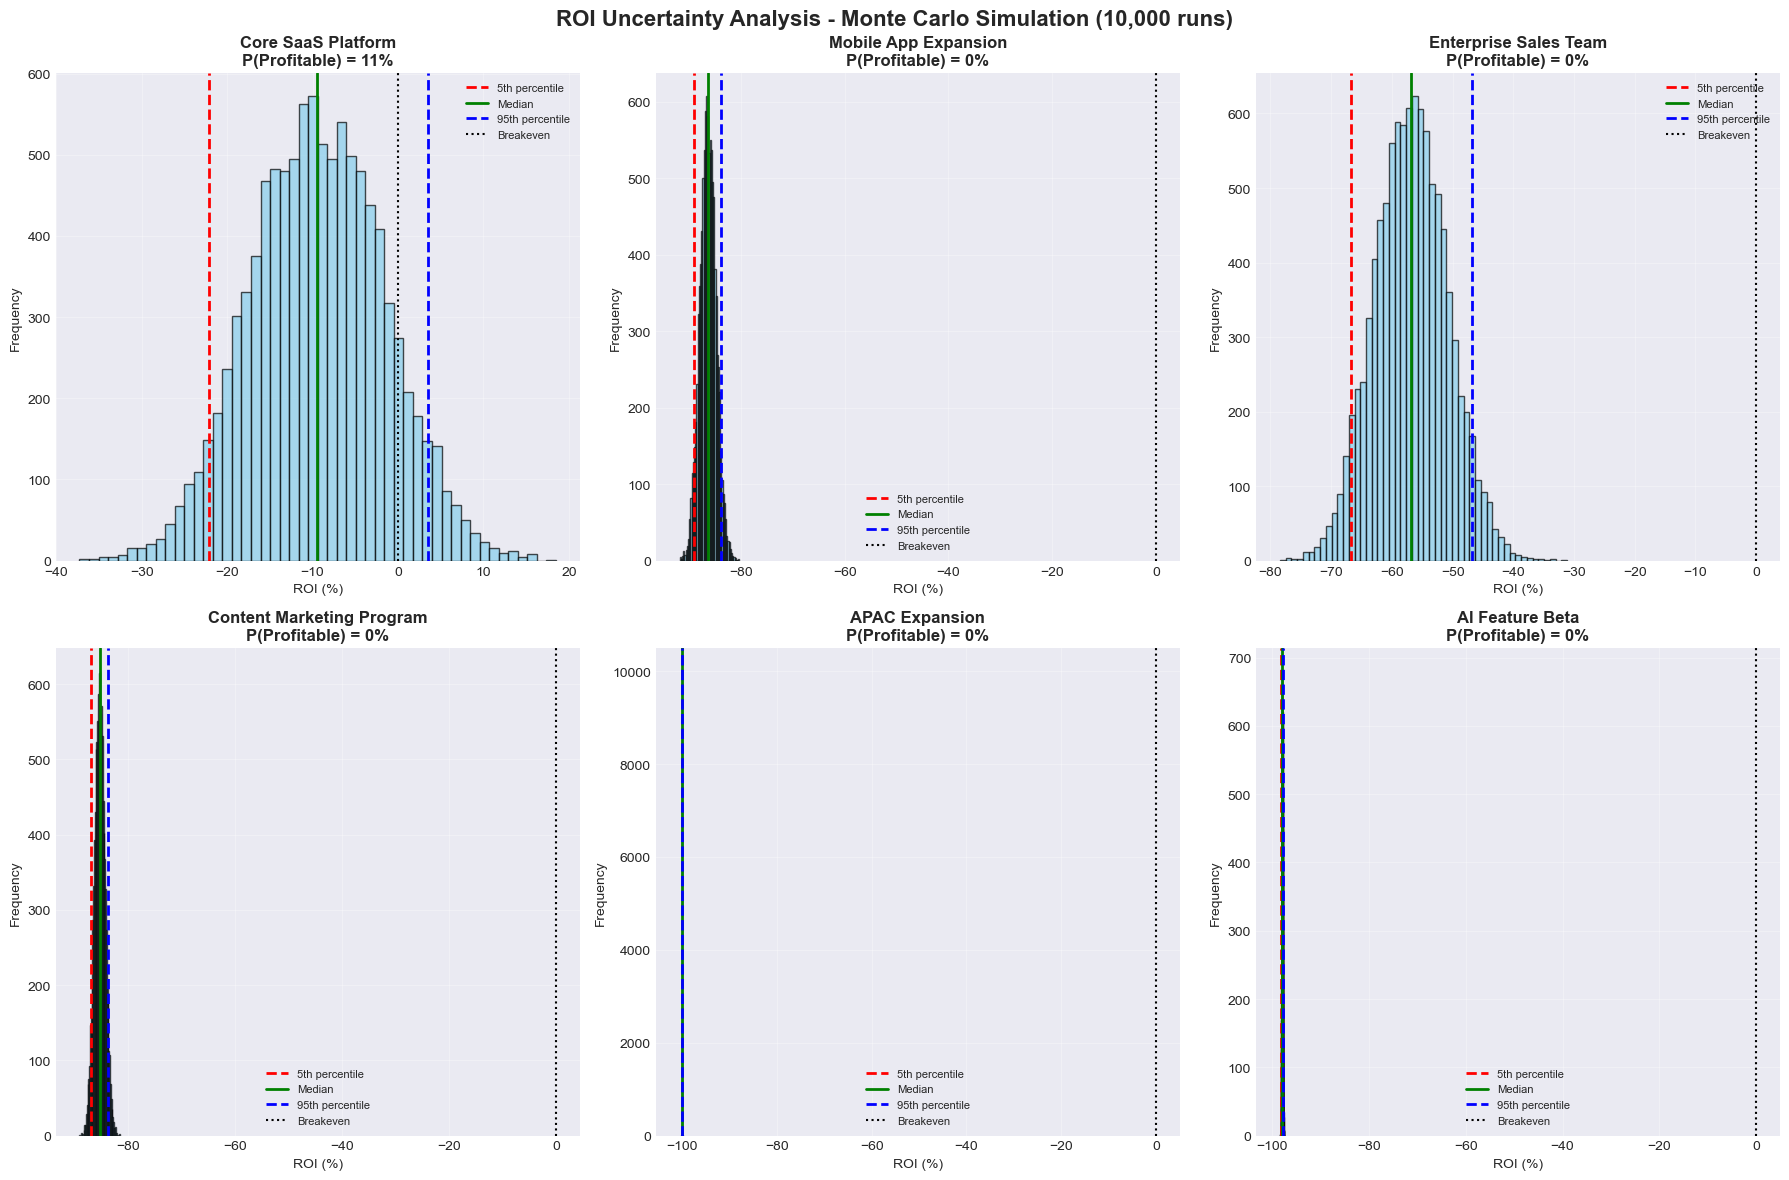

✅ Saved: 15_roi_uncertainty_bands.png


In [4]:
# ============================================
# VISUALIZATION 1: ROI UNCERTAINTY BANDS
# ============================================

print("\n📊 Creating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('ROI Uncertainty Analysis - Monte Carlo Simulation (10,000 runs)', 
             fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, (init_id, results) in enumerate(simulation_results.items()):
    ax = axes[idx]
    
    # Plot distribution
    ax.hist(results['simulated_rois'], bins=50, alpha=0.7, 
            color='skyblue', edgecolor='black')
    
    # Add confidence intervals
    ax.axvline(results['roi_5th_percentile'], color='red', 
               linestyle='--', linewidth=2, label='5th percentile')
    ax.axvline(results['roi_50th_percentile'], color='green', 
               linestyle='-', linewidth=2, label='Median')
    ax.axvline(results['roi_95th_percentile'], color='blue', 
               linestyle='--', linewidth=2, label='95th percentile')
    ax.axvline(0, color='black', linestyle=':', linewidth=1.5, 
               label='Breakeven')
    
    ax.set_title(f"{results['name']}\nP(Profitable) = {results['probability_profitable']:.0f}%",
                 fontweight='bold')
    ax.set_xlabel('ROI (%)')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("D:/Projects/End-to-end projects/7. Runway Kill-Switch Analytics/Documentation/15_roi_uncertainty_bands.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 15_roi_uncertainty_bands.png")

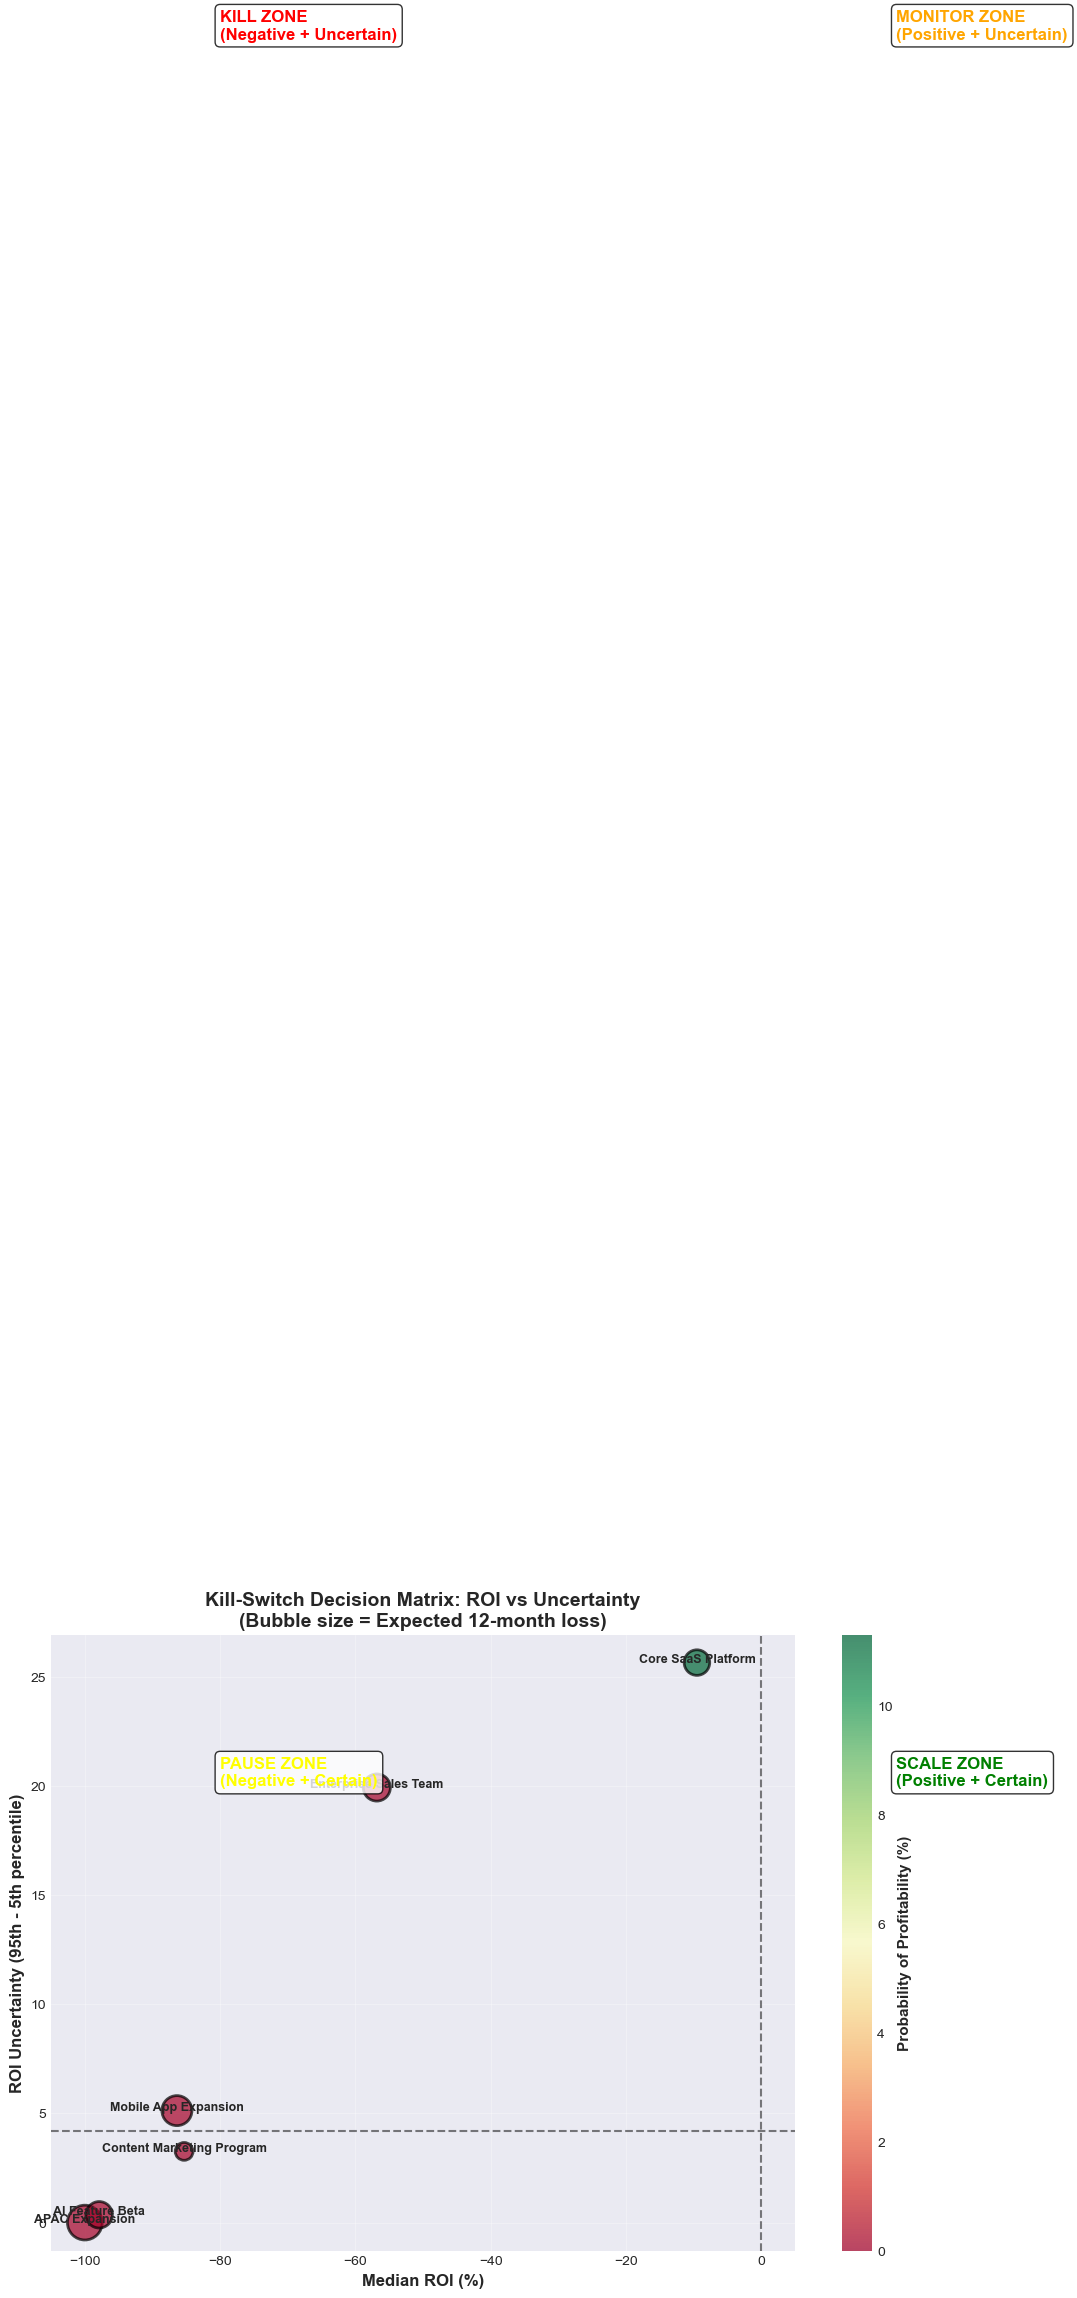

✅ Saved: 16_decision_confidence_matrix.png


In [5]:
# ============================================
# VISUALIZATION 2: DECISION CONFIDENCE MATRIX
# ============================================

fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for scatter plot
scatter_data = []
for init_id, results in simulation_results.items():
    scatter_data.append({
        'name': results['name'],
        'median_roi': results['roi_50th_percentile'],
        'roi_uncertainty': results['roi_95th_percentile'] - results['roi_5th_percentile'],
        'probability_profitable': results['probability_profitable'],
        'expected_12mo_loss': results['expected_12mo_loss']
    })

df_scatter = pd.DataFrame(scatter_data)

# Create scatter plot
scatter = ax.scatter(
    df_scatter['median_roi'], 
    df_scatter['roi_uncertainty'],
    s=abs(df_scatter['expected_12mo_loss']) / 1000,  # Size by potential loss
    c=df_scatter['probability_profitable'],
    cmap='RdYlGn',
    alpha=0.7,
    edgecolors='black',
    linewidths=2
)

# Add labels
for idx, row in df_scatter.iterrows():
    ax.annotate(
        row['name'],
        (row['median_roi'], row['roi_uncertainty']),
        fontsize=9,
        fontweight='bold',
        ha='center'
    )

# Add quadrant lines
ax.axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(df_scatter['roi_uncertainty'].median(), color='black', 
           linestyle='--', linewidth=1.5, alpha=0.5)

# Labels and zones
ax.text(-80, 100, 'KILL ZONE\n(Negative + Uncertain)', 
        fontsize=12, fontweight='bold', color='red',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(20, 100, 'MONITOR ZONE\n(Positive + Uncertain)', 
        fontsize=12, fontweight='bold', color='orange',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(-80, 20, 'PAUSE ZONE\n(Negative + Certain)', 
        fontsize=12, fontweight='bold', color='yellow',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(20, 20, 'SCALE ZONE\n(Positive + Certain)', 
        fontsize=12, fontweight='bold', color='green',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Median ROI (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('ROI Uncertainty (95th - 5th percentile)', fontsize=12, fontweight='bold')
ax.set_title('Kill-Switch Decision Matrix: ROI vs Uncertainty\n(Bubble size = Expected 12-month loss)',
             fontsize=14, fontweight='bold')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Probability of Profitability (%)', fontsize=11, fontweight='bold')

ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("D:/Projects/End-to-end projects/7. Runway Kill-Switch Analytics/Documentation/16_decision_confidence_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 16_decision_confidence_matrix.png")

In [6]:
# ============================================
# SUMMARY REPORT
# ============================================

print("\n" + "="*70)
print("KILL-SWITCH RECOMMENDATIONS WITH CONFIDENCE LEVELS")
print("="*70)

for init_id, results in simulation_results.items():
    print(f"\n{'='*70}")
    print(f"🎯 {results['name']}")
    print(f"{'='*70}")
    print(f"Median ROI:              {results['roi_50th_percentile']:>8.1f}%")
    print(f"90% Confidence Interval: {results['roi_5th_percentile']:>8.1f}% to {results['roi_95th_percentile']:>8.1f}%")
    print(f"Probability Profitable:  {results['probability_profitable']:>8.1f}%")
    print(f"Expected 12mo Loss:      ${results['expected_12mo_loss']:>10,.0f}")
    
    # Decision logic with confidence
    if results['roi_95th_percentile'] < -20:
        decision = "🔴 KILL IMMEDIATELY"
        confidence = "HIGH"
        reason = "Even best-case scenario (95th percentile) shows >20% loss"
    elif results['probability_profitable'] < 10:
        decision = "🔴 KILL"
        confidence = "HIGH"
        reason = f"Only {results['probability_profitable']:.0f}% chance of profitability"
    elif results['probability_profitable'] < 30:
        decision = "🟡 PAUSE"
        confidence = "MEDIUM"
        reason = f"Low probability of success ({results['probability_profitable']:.0f}%)"
    elif results['roi_50th_percentile'] > 20:
        decision = "🟢 SCALE"
        confidence = "HIGH"
        reason = "Strong median ROI with decent probability"
    else:
        decision = "🟢 CONTINUE"
        confidence = "LOW"
        reason = "Marginal performance, requires monitoring"
    
    print(f"\n🚦 DECISION: {decision}")
    print(f"💡 Confidence: {confidence}")
    print(f"📝 Reasoning: {reason}")


KILL-SWITCH RECOMMENDATIONS WITH CONFIDENCE LEVELS

🎯 Core SaaS Platform
Median ROI:                  -9.5%
90% Confidence Interval:    -22.1% to      3.5%
Probability Profitable:      11.3%
Expected 12mo Loss:      $  -337,781

🚦 DECISION: 🟡 PAUSE
💡 Confidence: MEDIUM
📝 Reasoning: Low probability of success (11%)

🎯 Mobile App Expansion
Median ROI:                 -86.4%
90% Confidence Interval:    -89.0% to    -83.8%
Probability Profitable:       0.0%
Expected 12mo Loss:      $   466,783

🚦 DECISION: 🔴 KILL IMMEDIATELY
💡 Confidence: HIGH
📝 Reasoning: Even best-case scenario (95th percentile) shows >20% loss

🎯 Enterprise Sales Team
Median ROI:                 -56.8%
90% Confidence Interval:    -66.7% to    -46.8%
Probability Profitable:       0.0%
Expected 12mo Loss:      $   381,568

🚦 DECISION: 🔴 KILL IMMEDIATELY
💡 Confidence: HIGH
📝 Reasoning: Even best-case scenario (95th percentile) shows >20% loss

🎯 Content Marketing Program
Median ROI:                 -85.3%
90% Confidence I

In [7]:
# ============================================
# EXPORT RESULTS
# ============================================

# Create summary dataframe
summary_data = []
for init_id, results in simulation_results.items():
    summary_data.append({
        'initiative_id': init_id,
        'initiative_name': results['name'],
        'median_roi': round(results['roi_50th_percentile'], 2),
        'roi_5th_percentile': round(results['roi_5th_percentile'], 2),
        'roi_95th_percentile': round(results['roi_95th_percentile'], 2),
        'probability_profitable': round(results['probability_profitable'], 1),
        'expected_12mo_loss': round(results['expected_12mo_loss'], 2)
    })

df_summary = pd.DataFrame(summary_data)
df_summary.to_csv("D:/Projects/End-to-end projects/7. Runway Kill-Switch Analytics/Data/roi_uncertainty_analysis.csv", index=False)
print("\n✅ Saved: roi_uncertainty_analysis.csv")

print("\n" + "="*70)
print("✅ ROI UNCERTAINTY ANALYSIS COMPLETE!")
print("="*70)


✅ Saved: roi_uncertainty_analysis.csv

✅ ROI UNCERTAINTY ANALYSIS COMPLETE!
